In [1]:
import matplotlib
%matplotlib inline
from matplotlib.colors import LogNorm
import yt

In [2]:
from SZmaps.IO import get_fits_data as gf
reload(gf)
yt_datastruct = gf.create_yt_datastruc_from_cubes('/home/babyostrich/data/L500_fits/','1.0005',1, 6)
dd = yt_datastruct.all_data()

yt : [INFO     ] 2017-07-03 12:20:27,367 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-07-03 12:20:27,368 Parameters: domain_dimensions         = [ 256.  256.  256.]
yt : [INFO     ] 2017-07-03 12:20:27,369 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-03 12:20:27,371 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-07-03 12:20:27,373 Parameters: cosmological_simulation   = 0.0


in units of omM


In [3]:
from astropy.io.fits import getdata
import yt.utilities.cosmology as cosmology

Lv5rhogas = getdata('/home/babyostrich/data/L500_fits/rhogas_a1.0005_CL2_N256_Lv5.fits')
Lv6rhogas = getdata('/home/babyostrich/data/L500_fits/rhogas_a1.0005_CL2_N256_Lv6.fits')
Lv5T = getdata('/home/babyostrich/data/L500_fits/temperature_a1.0005_CL2_N256_Lv5.fits')

Lv6T = getdata('/home/babyostrich/data/L500_fits/temperature_a1.0005_CL2_N256_Lv6.fits')


2.18121554358e-32 8673.53387451


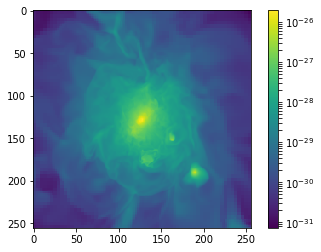

In [4]:
import matplotlib.pyplot as plt
plt.imshow(Lv5rhogas[:,:,128],norm=LogNorm())
plt.colorbar()
print Lv5rhogas.min(), Lv6rhogas.max()

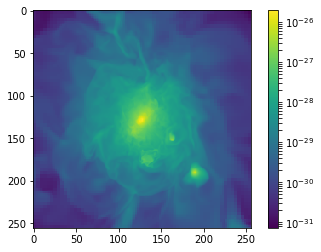

In [5]:
import matplotlib.pyplot as plt
plt.imshow(Lv5rhogas[:,:,128],norm=LogNorm())
plt.colorbar()

yt : [INFO     ] 2017-07-03 12:20:29,936 xlim = 0.000000 1.000000
yt : [INFO     ] 2017-07-03 12:20:29,938 ylim = 0.000000 1.000000
yt : [INFO     ] 2017-07-03 12:20:29,942 xlim = 0.000000 1.000000
yt : [INFO     ] 2017-07-03 12:20:29,944 ylim = 0.000000 1.000000
yt : [INFO     ] 2017-07-03 12:20:29,947 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800
yt : [INFO     ] 2017-07-03 12:20:30,017 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2017-07-03 12:20:30,034 Making a fixed resolution buffer of (('gas', 'szy')) 800 by 800
yt : [INFO     ] 2017-07-03 12:20:30,969 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800
yt : [INFO     ] 2017-07-03 12:20:30,984 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2017-07-03 12:20:31,003 Making a fixed resolution buffer of (('gas', 'szy')) 800 by 800


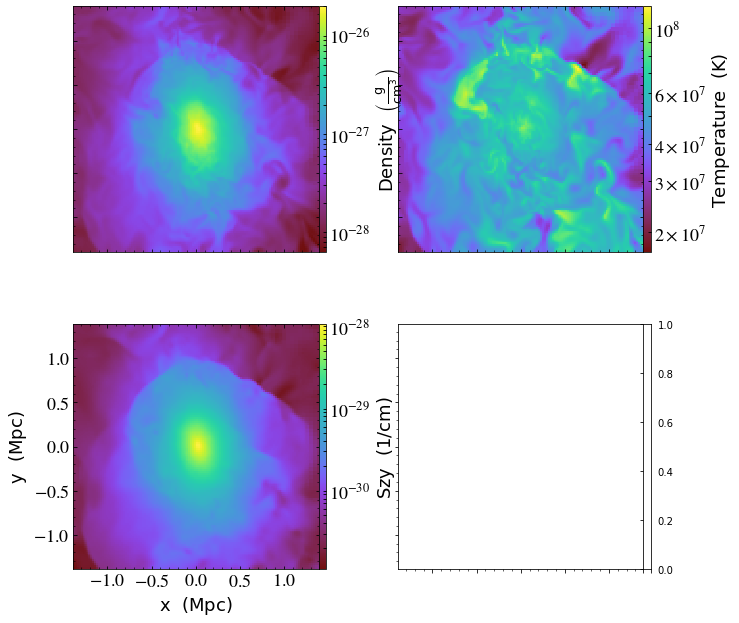

In [6]:
# Test datastructure: multi-plot projection of T, rho, SZ, and velocity
# http://yt-project.org/doc/cookbook/complex_plots.html
import yt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

fig = plt.figure()

grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (2, 2),
                axes_pad = 1.0,
                label_mode = "1",
                share_all = True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%",
                cbar_pad="0%")

fields = ['density', 'temperature', 'szy']

# Create the plot.  Since SlicePlot accepts a list of fields, we need only
# do this once.
p = yt.SlicePlot(yt_datastruct, 'z', fields)

p.zoom(2)

# For each plotted field, force the SlicePlot to redraw itself onto the AxesGrid
# axes.
for i, field in enumerate(fields):
    plot = p.plots[field]
    plot.figure = fig
    plot.axes = grid[i].axes
    plot.cax = grid.cbar_axes[i]

# Finally, redraw the plot on the AxesGrid axes.
p._setup_plots()

In [7]:
# Test reading in database, using database to delineate the r500c, r200m borders
import SZmaps.IO.database as db
from yt.units import kpc
halo_ids = db.sim.get_halo_ids()
halo_props = db.collect_halo_props(halo_ids)
r200m = halo_props['r200m'][0] 
r500c = halo_props['r500c'][0] 

looking in /home/babyostrich/data/databases/ for L500_NR_0.db


Annotate projections, and calculate integrated quantities in sphere and cylinder along all lines of sight.

yt : [INFO     ] 2017-07-03 12:20:35,684 Projection completed
yt : [INFO     ] 2017-07-03 12:20:35,685 xlim = 0.185344 0.814656
yt : [INFO     ] 2017-07-03 12:20:35,686 ylim = 0.185344 0.814656
yt : [INFO     ] 2017-07-03 12:20:35,688 xlim = 0.185344 0.814656
yt : [INFO     ] 2017-07-03 12:20:35,689 ylim = 0.185344 0.814656
yt : [INFO     ] 2017-07-03 12:20:35,691 Making a fixed resolution buffer of (('gas', 'szy')) 800 by 800



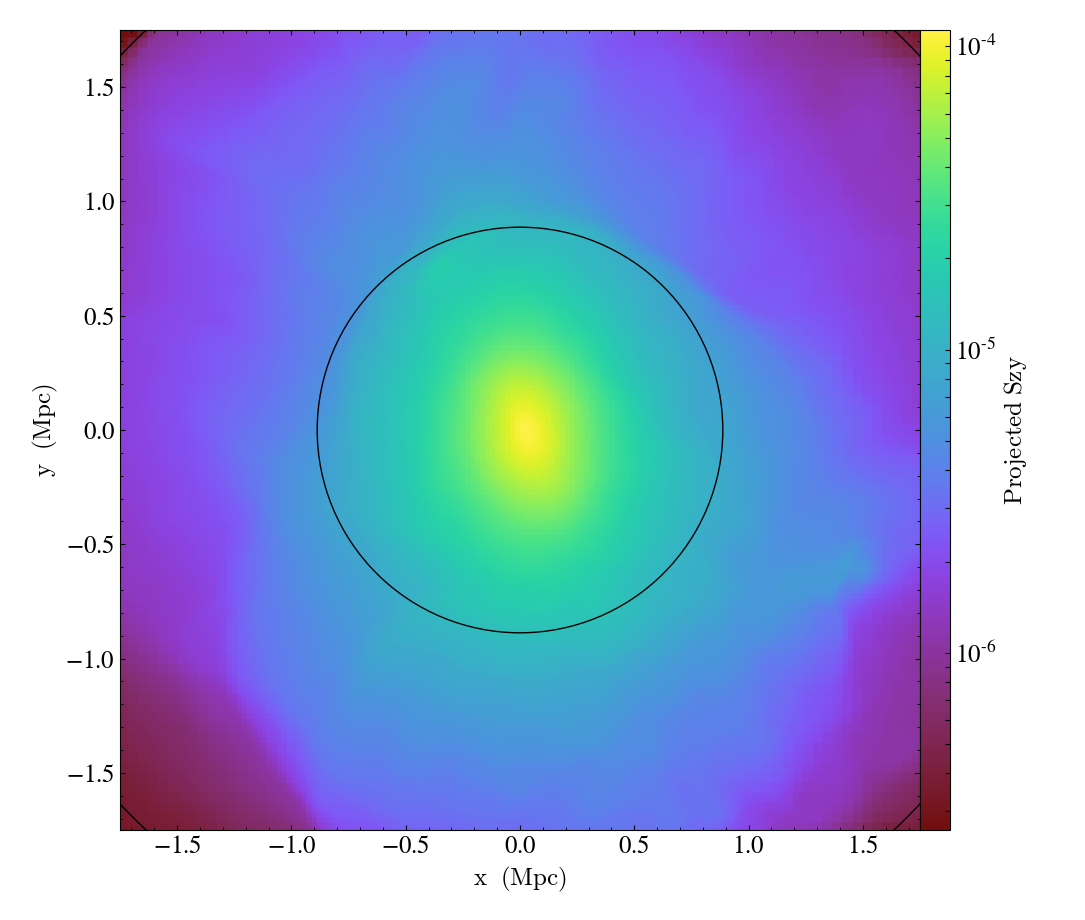

In [8]:
from yt.units import Mpc
axis = 2
p = yt.ProjectionPlot(yt_datastruct, axis, 'szy', width=3.5*Mpc)
p.annotate_sphere([0.5, 0.5, 0.5], radius=(r500c, 'kpc'),
                  circle_args={'color':'black'})
p.annotate_sphere([0.5, 0.5, 0.5], radius=(r200m, 'kpc'),
                  circle_args={'color':'black'})

Let's calculate the angular diameter distance for a cluster that sits at observational redshift of zf = 0.02.

In [9]:
from yt.utilities.cosmology import Cosmology
cosmo = Cosmology()
(zi, zf) = (0,0.02)
dA = cosmo.angular_diameter_distance(zi,zf).in_units('Mpc')
cosmo.omega_matter

0.27

Next, let's integrate in a sphere and in a cylinder, plot in each direction, and plot.
Sphere: http://yt-project.org/doc/reference/api/generated/yt.data_objects.selection_data_containers.YTSphere.html#yt.data_objects.selection_data_containers.YTSphere


In [10]:
sphere = yt_datastruct.sphere([0.5,0.5,0.5],(r500c,'kpc'))
print sphere.volume().in_units('Mpc**3') * sphere['szy'].sum().in_units('1/Mpc') / dA**2 
print sphere.volume().in_units('Mpc**3') * sphere['szy'].sum().in_units('1/Mpc')
print sphere.volume().in_units('kpc**3') / sphere['szy'].size
print sphere['szy'].sum().in_units('1/Mpc')
print dA
print (sphere['szy'].sum().in_units('1/Mpc') *( 3.6 * 4/0.7 )**3 * kpc**3 ).in_units('Mpc**2')

0.00193156643781 dimensionless
13.1299645466 Mpc**2
10253.8727297 kpc**3
4.49067259855 1/Mpc
82.4473974888 Mpc
3.90935175758e-05 Mpc**2


Cylinder: http://yt-project.org/doc/reference/api/generated/yt.data_objects.selection_data_containers.YTDisk.html#yt.data_objects.selection_data_containers.YTDisk

In [11]:
center = [0.5]*3
normal = [1,0,0]
radius = r500c
depth = 3.*r500c
cylinder = yt_datastruct.disk(center, normal, (radius,'kpc'), (depth, 'kpc'))
cylinder.volume().in_units('Mpc**3') / cylinder['szy'].size * cylinder['szy'].sum().in_units('1/Mpc') 

5.71473485538e-05 Mpc**2

To do:

(1)  Script up the loading and sphere calculation of a halo.  Done. 

(2)  Integrate the r500c quantity in determining the sphere's extent. Done.

(3)  Make a Ysz vs. mass plot. Done.

(4)  Do (1)-(3) for a cylinder. Done.

(5)  Do the same thing for outskirt annuli or outskirt shells - this should basically just pick up the scatter from the Ysz vs. mass scaling.

In [12]:
import pandas as pd
szy_df = pd.read_csv('/home/babyostrich/Repos/SZmaps/calculate_scaling/szyscaling.csv',sep=' ')

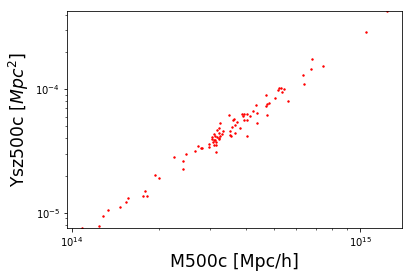

In [13]:
# Scatter plot of spherically integrated Ysz
plt.scatter(szy_df['M500c'],szy_df['Ysz500c'],s=2.,c='r')
plt.xscale('log')
plt.yscale('log')
plt.ylim((szy_df['Ysz500c'].min(),szy_df['Ysz500c'].max()) )
plt.ylabel('Ysz500c [$Mpc^2$]',fontsize='xx-large')
plt.xlabel('M500c [Mpc/h]',fontsize='xx-large')

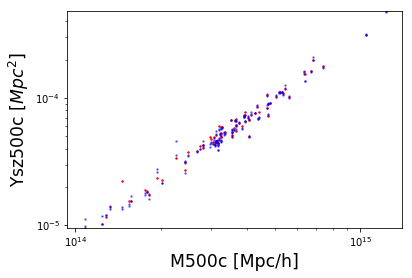

In [14]:
# Scatter plot of cylindrically integrated Ysz
plt.scatter(szy_df['M500c'],szy_df['Yszcyl_x'],s=2.,c='r')
plt.scatter(szy_df['M500c'],szy_df['Yszcyl_y'],s=2.,c='b',alpha=0.5)
plt.scatter(szy_df['M500c'],szy_df['Yszcyl_z'],s=2.,c='b',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylim((szy_df['Yszcyl_x'].min(),szy_df['Yszcyl_x'].max()) )
plt.ylabel('Ysz500c [$Mpc^2$]',fontsize='xx-large')
plt.xlabel('M500c [Mpc/h]',fontsize='xx-large')

In the next steps, I'll look at the integrated szy between r500c and r200c (and r200m), and how that compares with the values at z=1.  

In [459]:
szy_z0 = pd.read_csv('/home/babyostrich/Repos/SZmaps/calculate_scaling/szyscaling_a1.0005.csv',sep=' ')
szy_z1 = pd.read_csv('/home/babyostrich/Repos/SZmaps/calculate_scaling/szyscaling_a0.5014.csv',sep=' ')
szy_df = pd.read_csv('/home/babyostrich/Repos/SZmaps/calculate_scaling/szyscaling_a1.0005_Lv6.csv',sep=' ')


In [460]:
def plot_Ym_scatter( dataframe, rtype='500c', region='Yszr',
                    annotate_fit=True) :
    plt.scatter(dataframe['M'+rtype],dataframe[region+rtype],s=2.,c='r')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim((dataframe[region+rtype].min(),dataframe[region+rtype].max()) )
    plt.ylabel('Y$_{\\rm{sz},'+rtype+'}$ [Mpc$^2$]',fontsize='xx-large')
    plt.xlabel('M$_{\\rm{'+rtype+'}}$ [Mpc/h]',fontsize='xx-large')
    if annotate_fit: 
        lnA14, alpha = fit_scatter(dataframe, rtype=rtype, region=region)
        plt.plot( dataframe['M'+rtype], 
                  np.exp(scaling_relation(dataframe['M'+rtype], lnA14, alpha)),
                  ls='--',lw=.3,c='k',alpha=0.5)
        plt.figtext(.15,.8,'ln$A_{14}$=%f, $\\alpha$=%f' % (lnA14, alpha), 
                    fontsize='x-large')
    

In [473]:
def scaling_relation(M, lnA14, alpha):#, beta) :
    import numpy as np
    from astropy.cosmology import FlatLambdaCDM
    flatcosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    #  Need to check if Ez is used when fitting.
    #if M.min() < 8e13 : # z=1
    #    Ez = np.sqrt((1+1)**3 * 0.3 + 0.7)
    #else :
    #    Ez = 1.
    return lnA14 + alpha * np.log(M/1e14)#+ beta*np.log(1./Ez)
    
def fit_scatter(dataframe, rtype='500c', region='Yszr') :
    from scipy.optimize import curve_fit
    import numpy as np
    xdata = dataframe['M'+rtype].values
    ydata = np.log(np.array(dataframe[region+rtype].values))
    (lnA14,alpha), pcov = curve_fit(scaling_relation, xdata, ydata )
    return lnA14, alpha

First, the scatterplots of Y-M500c, Y-M200c, and Y-M200m at z=0 and z=1 in spheres and cylinders

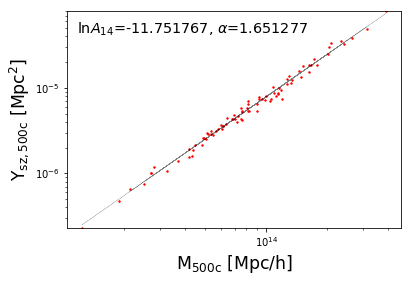

In [474]:
plot_Ym_scatter(szy_z1, rtype='500c')

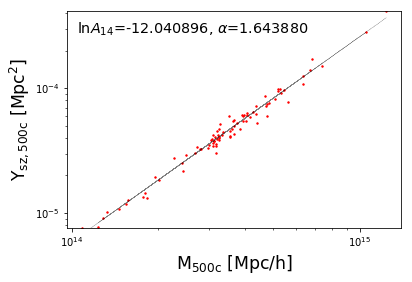

In [475]:
plot_Ym_scatter(szy_z0, rtype='500c')

Compare with the z=0 Ysz(r500c) data from Lv6.  Close enough....

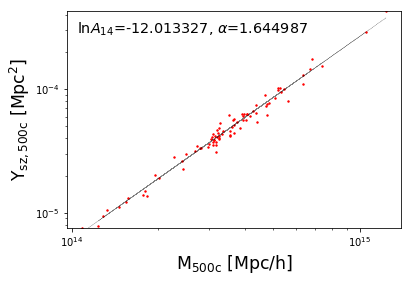

In [476]:
plot_Ym_scatter(szy_df)

Here are the r200c and r200m scalings at z=1, and z=0.

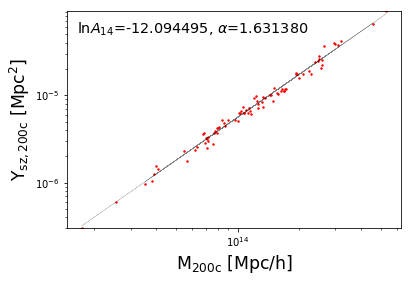

In [477]:
plot_Ym_scatter(szy_z1, rtype='200c')

The plot below has best fit parameters that are a bit different from the ones found in Yu+15 ( lnA14, alpha = -12.11, 1.56 ).  I should check the output of Lv6 to see if this is a resolution dependent effect.

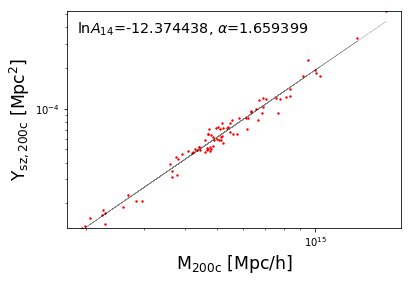

In [467]:
plot_Ym_scatter(szy_df, rtype='200c')

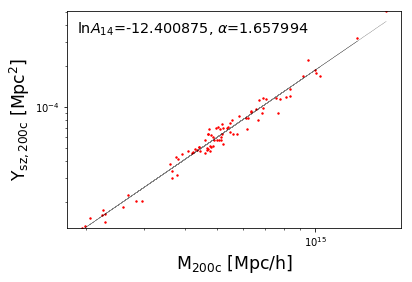

In [466]:
plot_Ym_scatter(szy_z0, rtype='200c')

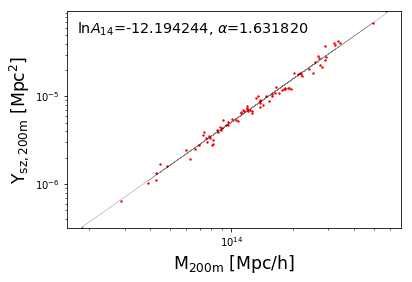

In [298]:
plot_Ym_scatter(szy_z1, rtype='200m')

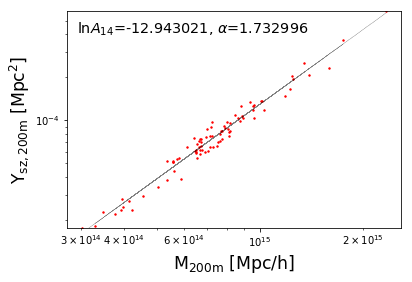

In [299]:
plot_Ym_scatter(szy_z0, rtype='200m')

Now to look at the best-fit values for cylindrical projections

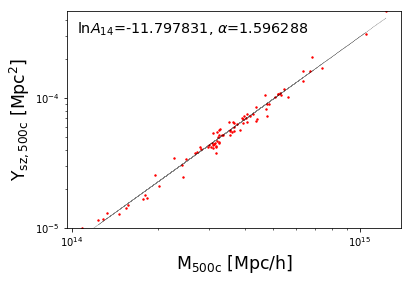

In [300]:
plot_Ym_scatter(szy_z0, rtype='500c',region='Yszcyl_z_r')

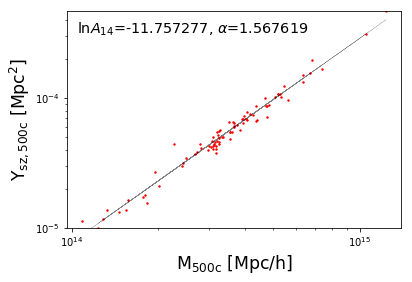

In [288]:
plot_Ym_scatter(szy_z0, rtype='500c',region='Yszcyl_y_r')

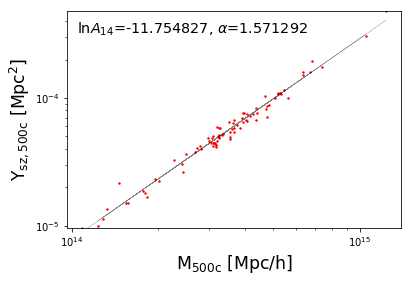

In [289]:
plot_Ym_scatter(szy_z0, rtype='500c',region='Yszcyl_x_r')

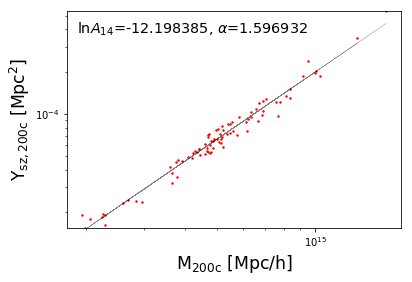

In [290]:
plot_Ym_scatter(szy_z0, rtype='200c',region='Yszcyl_z_r')

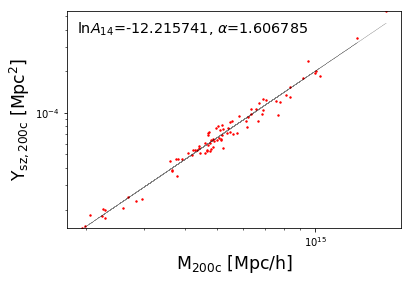

In [291]:
plot_Ym_scatter(szy_z0, rtype='200c',region='Yszcyl_y_r')

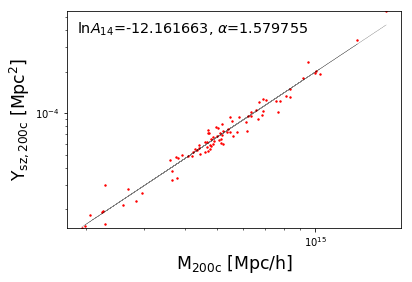

In [292]:
plot_Ym_scatter(szy_z0, rtype='200c',region='Yszcyl_x_r')

In the next step, we will see how well we can "scale out" the mass, then redshift dependence.  

In [488]:
def plot_YM_scaled(dataframe, rtype='500c',region='Yszr',
                   get_scaling=True, fit_scatter_output=None, scale_by_aexp=None, **plot_kwargs) :
    if get_scaling :
        lnA14, alpha = fit_scatter(dataframe, rtype=rtype, region=region)
        assert(fit_scatter_output == None )
    else : 
        lnA14, alpha = fit_scatter_output
        assert(fit_scatter_output !=None )

    scaledY = dataframe[region+rtype]/   \
            (dataframe['M'+rtype]/1e14)**alpha/np.exp(lnA14)

    if scale_by_aexp != None :
        print "scaling out a redshift dependence"
        scaledY *= (cosmo.inverse_expansion_factor(1./float(scale_by_aexp) - 1.))**(2/3) 
                
        
    plt.scatter(dataframe['M'+rtype],scaledY, **plot_kwargs)
    plt.xscale('log')
    plt.ylabel('Y$_{\\rm{sz},'+rtype+'}$ [Mpc$^2$]/M$^\\alpha$',fontsize='xx-large')
    plt.xlabel('M$_{\\rm{'+rtype+'}}$ [Mpc/h]',fontsize='xx-large')

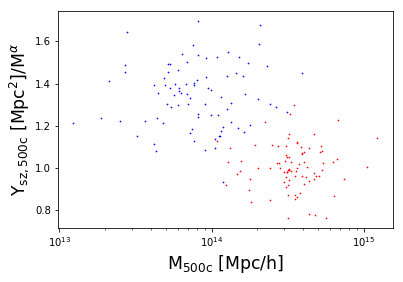

In [489]:
# Scaling out the mass dependence according to the best fit lnA14 and alpha
plot_YM_scaled(szy_z0,s=0.5,c='r')
plot_YM_scaled(szy_z1, get_scaling=False, 
               fit_scatter_output=fit_scatter(szy_z0),s=0.5,c='b')


Let's see how well the r200c best fit values at z=0 scale out the redshift dependence.

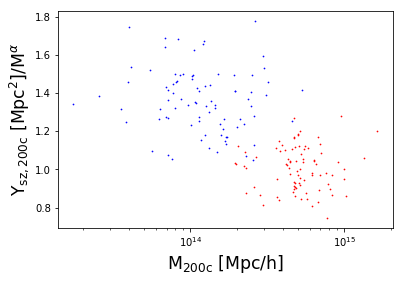

In [490]:
# Scaling out the mass dependence according to the best fit lnA14 and alpha
rtype = '200c'
plot_YM_scaled(szy_z0,rtype=rtype,s=0.5,c='r')
plot_YM_scaled(szy_z1, rtype=rtype,get_scaling=False, 
               fit_scatter_output=fit_scatter(szy_z0,rtype=rtype),
               #scale_by_aexp='0.5014',
               s=0.5,c='b')


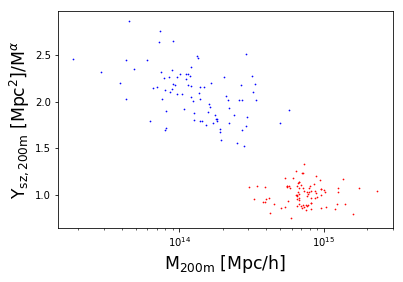

In [491]:
# Scaling out the mass dependence according to the best fit lnA14 and alpha
rtype='200m'
plot_YM_scaled(szy_z0,rtype=rtype,s=0.5,c='r')
plot_YM_scaled(szy_z1, rtype=rtype,get_scaling=False,
               #scale_by_aexp='0.5014',
               fit_scatter_output=fit_scatter(szy_z0,rtype=rtype),s=0.5,c='b')


Let's look at any possible evolution in cylinders

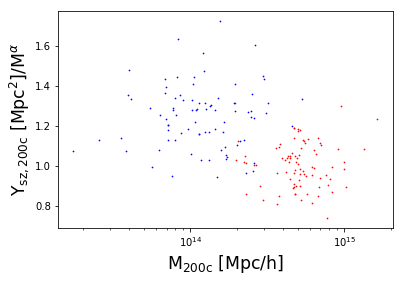

In [492]:
# Scaling out the mass dependence according to the best fit lnA14 and alpha
rtype, region ='200c', 'Yszcyl_z_r'
plot_YM_scaled(szy_z0,rtype=rtype,region=region,s=0.5,c='r')
plot_YM_scaled(szy_z1, rtype=rtype, region=region,get_scaling=False,
               fit_scatter_output=fit_scatter(szy_z0,rtype=rtype,region=region),
               s=0.5,c='b')


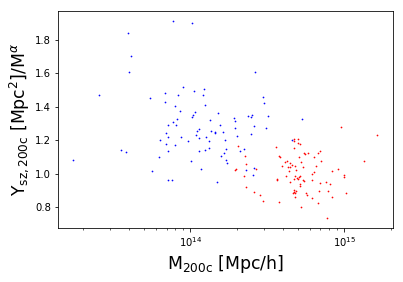

In [493]:
# Scaling out the mass dependence according to the best fit lnA14 and alpha
rtype, region ='200c', 'Yszcyl_y_r'
plot_YM_scaled(szy_z0,rtype=rtype,region=region,s=0.5,c='r')
plot_YM_scaled(szy_z1, rtype=rtype, region=region,get_scaling=False, 
               #scale_by_aexp='0.5015',
               fit_scatter_output=fit_scatter(szy_z0,rtype=rtype,region=region),
               s=0.5,c='b')


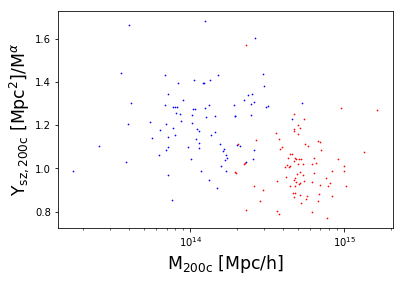

In [494]:
# Scaling out the mass dependence according to the best fit lnA14 and alpha
rtype, region ='200c', 'Yszcyl_x_r'
plot_YM_scaled(szy_z0,rtype=rtype,region=region,s=0.5,c='r')
plot_YM_scaled(szy_z1, rtype=rtype, region=region, get_scaling=False, 
               #scale_by_aexp='0.5015',
               fit_scatter_output=fit_scatter(szy_z0,rtype=rtype,region=region),
               s=0.5,c='b')


Now, we plot the average blue and the average red with errorbars of the stdev.

In [495]:
def calc_avg_scaled_Y(dataframe, rtype='500c',region='Yszr',
                       get_scaling=True, fit_scatter_output=None, 
                          scale_by_aexp=None) :
    if get_scaling :
        lnA14, alpha = fit_scatter(dataframe, rtype=rtype, region=region)
        assert(fit_scatter_output == None)
    else : 
        lnA14, alpha = fit_scatter_output
        assert(fit_scatter_output !=None )

    scaledY = dataframe[region+rtype]/   \
            (dataframe['M'+rtype]/1e14)**alpha/np.exp(lnA14)
    if scale_by_aexp != None :
        scaledY *= cosmo.inverse_expansion_factor(1./float(scale_by_aexp) - 1.) 
                
    return scaledY.mean(), scaledY.std()

In [500]:
print 'z=0 at r500c, (Yavg, std)=', calc_avg_scaled_Y(szy_z0)
print 'z=1 at r500c, (Yavg, std)=', calc_avg_scaled_Y(szy_z1, get_scaling=False, #scale_by_aexp='0.5014',
                                                      fit_scatter_output=fit_scatter(szy_z0))
rtype='200c'
print 'z=0 at r200c, (Yavg, std)=', calc_avg_scaled_Y(szy_z0,rtype=rtype) 
print 'z=1 at r200c, (Yavg, std)=',calc_avg_scaled_Y(szy_z1, get_scaling=False, #scale_by_aexp='0.5014',
                                                     rtype=rtype, 
                                                    fit_scatter_output=fit_scatter(szy_z0,rtype=rtype))
rtype='200m'
print 'z=0 at r200m, (Yavg, std)=', calc_avg_scaled_Y(szy_z0,rtype=rtype)
print 'z=1 at r200m, (Yavg, std)=',calc_avg_scaled_Y(szy_z1, get_scaling=False, #scale_by_aexp='0.5014',
                                                    rtype=rtype, 
                                                    fit_scatter_output=fit_scatter(szy_z0,rtype=rtype))


z=0 at r500c, (Yavg, std)= (1.0056178951481747, 0.10637142774053082)
z=1 at r500c, (Yavg, std)= (1.3414781809372496, 0.14956819730810189)
z=0 at r200c, (Yavg, std)= (1.0064760189929223, 0.11462075027991489)
z=1 at r200c, (Yavg, std)= (1.3627626574227083, 0.16708923753637273)
z=0 at r200m, (Yavg, std)= (1.006598554773297, 0.11618245346990717)
z=1 at r200m, (Yavg, std)= (2.0784490576703778, 0.27849733521802572)


To do: Here, we plot the scaled scatter of the Ysz value between $r500c<R< r200c$, then $r500c<R<r200m$.